# VAE：变分自编码器学习
同样，这也是为了给DDPM打基础，因此只是粗略学习了VAE的原理和ELBO函数的实现（后面的数学公式太难了我真的看不下去了T_T）

In [39]:
from graphviz import Digraph
import matplotlib.pyplot as plt
from PIL import Image

### 自编码器原理

                 编码器               解码器
原数据 $X$ -->(特征提取，压缩)--> 编码 $Z$ --> 解码 $X'$ --> $L(X,X')$ --> 更新编/解码器参数

### 变分自编码器
#### VAE 的数学建模
假设我们的数据 $x$ 是由某种随机过程生成的，我们记为
$$
p(x) = \int p_{\theta^*}(x \mid z)p_{\theta^*}(z) dz
$$
其中 $\theta^*$ 是该分布的参数，$z$ 是隐变量，$x$ 是观测变量。

##### 编码器
现在，我们希望模型训练一个生成器，它不仅能像 AE 那样生成相似的数据（比如给定一朵花，AE 生成一朵一模一样的花），还能生成“没见过”的数据，因此我们就需要了解 $z$ 的分布，因为 $z$ 控制着 $x$ 的生成：
$$
\mathbf{want ~ to ~ know: ~~} p(z \mid x)
$$

然而我们无法知道 $z$ 的分布，因此我们采用变分推断来近似地估计 $z$ 的分布：引入参数 $\phi$，构造近似后验分布（这里采用正态分布）$q_{\phi}(z \mid x)$。根据输入 $x$，我们可以得到 $z$ 的分布。这就是编码器：**返回 $z$ 的分布**
##### 重参数化技巧
我们从分布中采样一个 $z_0$ 送给解码器解码，为了让后续可以计算 $z$ 的梯度，我们需要对 $z$ 进行重参数化：
$$
z = \mu + \sigma \odot \epsilon
$$
这样我们就可以计算梯度了。
##### 解码器
编码器让我们知道了 $z$ 的分布可能如何，接下来我们就需要利用 $z$ 来生成数据 $x'$ 模拟原始数据。一般情况下我们可以把解码器视作一个神经网络，参数为 $\theta$。

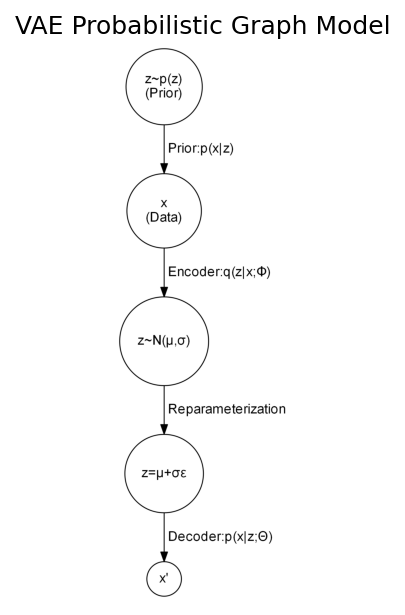

In [44]:


dot = Digraph(comment='VAE Probabilistic Graph Model', node_attr={'fontname': 'Helvetica,Arial,sans-serif'},
              edge_attr={'fontname': 'Helvetica,Arial,sans-serif'})
dot.attr(dpi='300')

dot.node('zt', 'z~p(z)\n(Prior)', shape='circle')
dot.node('x', 'x\n(Data)', shape='circle')
dot.node('z', 'z~N(μ,σ)', shape='circle')
dot.node('zr', 'z=μ+σε', shape='circle')
dot.node('xb', 'x\'', shape='circle')

dot.edge('zt', 'x', label=' Prior:p(x|z)')
dot.edge('x', 'z', label=' Encoder:q(z|x;Φ)')
dot.edge('z', 'zr', label=' Reparameterization')
dot.edge('zr', 'xb', label=' Decoder:p(x|z;Θ)')

img_path = 'vae_probabilistic_graph'
dot.render(img_path, format='png', cleanup=True, view=False)

# 使用 matplotlib 显示图像
img = Image.open(f'{img_path}.png')
plt.title('VAE Probabilistic Graph Model')
plt.rcParams['figure.dpi'] = 100
plt.imshow(img)
plt.axis('off')
plt.show()

上图展示了训练时的工作流程（不含参数更新），其中模型需要学习的参数是 $\phi$ 和 $\theta$

#### 优化目标函数 $\mathrm{ELBO}(\phi,\theta)$
我们的目标是使得 $p_{\phi}(z \mid x)$ 尽可能接近真实后验 $p(z \mid x)$，因此我们可以使用 KL 散度来度量两个分布之间的差异，即
$$
\begin{gathered}
D_{KL}(q_{\phi}(z|x)||p(z|x))=-\sum_{z}q_{\phi}(z|x)\log\left(\frac{p(z|x)}{q_{\phi}(z|x)}\right)=-\sum_{\mathrm{z}}q_{\phi}(z|x)\log\left(\frac{\frac{p(x,z)}{p(x)}}{q_{\phi}(z|x)}\right) \\
=-\sum_{z}q_{\phi}(z|x)\left[\log\left(\frac{p(x,z)}{q_{\phi}(z|x)}\right)-\log\left(p(x)\right)\right] \\
=log(p(x)) - \sum_{z}q_{\phi}(z|x)\log\left(\frac{p(x,z)}{q_{\phi}(z|x)}\right)
\end{gathered}
$$
即：
$$
\begin{gathered}
log(p(x)) = D_{KL} + \sum_{z}q_{\phi}(z|x)\log\left(\frac{p(x,z)}{q_{\phi}(z|x)}\right) \\
\end{gathered}

由于左边是常数，DL散度具有非负性，因此最小化KL散度等价于最大化 ELBO：
$$
\mathrm{ELBO}(\phi,\theta) = \sum_{z}q_{\phi}(z|x)\log\left(\frac{p(x,z)}{q_{\phi}(z|x)}\right)
$$
根据期望性质：
$$
\mathrm{ELBO}(\phi,\theta) = \mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x\mid z)p(z)] - \mathbb{E}_{q_{\phi}(z|x)}[\log q_{\phi}(z|x)]
$$
为什么 $p(x,z)$ 可以拆成 $p_{\theta}(x\mid z)p(z)$ ？**有没有人能告诉我**